In [1]:
import pandas as pd
import creds
from sqlalchemy import create_engine, text as sa_text
from scipy import stats
import requests

In [2]:
# Construct the connection string using your credentials
con_string = f"postgresql+psycopg2://{creds.DB_USER}:{creds.DB_PASS}@{creds.DB_HOST}/{creds.DB_NAME}"

# Create a database engine and connect to the database
engine = create_engine(con_string)
conn = engine.connect()

xg_df = pd.read_sql_query(sa_text('SELECT * FROM expect_goals'), con=conn)
pbp_df = pd.read_sql_query(sa_text('SELECT * FROM play_by_play'), con=conn)

conn.commit()
conn.close()

In [3]:
pbp_xg_df = pd.merge(left=pbp_df, right=xg_df, on=['gameId','playId'], how='inner')

In [4]:
engine = create_engine(con_string)
conn = engine.connect()

player_stats_db = pd.read_sql_query(sa_text('SELECT * FROM skater_stats'), con=conn)


conn.commit()
conn.close()

In [43]:
gf_dict = {}
home_cols = [f'home{i}' for i in range(1, 7)]
away_cols = [f'away{i}' for i in range(1, 7)]
player_cols = home_cols + away_cols + ["eventPlayer1"]
player_ids = player_stats_db.id.unique()
pbp_xg_df["eventPlayer1"] = pbp_xg_df["eventPlayer1"].astype('object')

for player_id in player_ids:
    player_scope = pbp_xg_df[pbp_xg_df[player_cols].eq(str(player_id)).any(axis=1)]
    seasons = player_scope['season'].unique()
    for season in seasons:
        xg_dict = {}
        season_scope = player_scope[player_scope['season'] == season]
        for strength in ['EV', 'PP', 'SH']:
            strength_scope = season_scope[season_scope['strength'] == strength]
            xg_dict[f'{strength}_ixG'] = strength_scope[strength_scope['eventPlayer1'].eq(player_id)]['xG'].sum()
            home_on_ice_filter = (strength_scope[home_cols].eq(str(player_id)).any(axis=1))
            away_on_ice_filter = (strength_scope[away_cols].eq(str(player_id)).any(axis=1))
            
            xg_dict[f'{strength}_xGF'] = strength_scope.loc[(home_on_ice_filter & (season_scope['homeTeam'] == season_scope['eventTeam'])) | (away_on_ice_filter & (season_scope['awayTeam'] == season_scope['eventTeam'])), 'xG'].sum()
            xg_dict[f'{strength}_xGA'] = strength_scope.loc[(home_on_ice_filter & (season_scope['homeTeam'] != season_scope['eventTeam'])) | (away_on_ice_filter & (season_scope['awayTeam'] != season_scope['eventTeam'])), 'xG'].sum()

        gf_dict[(player_id, season)] = xg_dict




In [81]:
df = pd.DataFrame(gf_dict).transpose().reset_index().rename({'level_0':'id','level_1':'season'}, axis='columns')

In [82]:
player_stats_db.columns

Index(['id', 'season', 'games', 'goals', 'assists', 'points', 'shots',
       'shotPct', 'pim', 'timeOnIce', 'evenTimeOnIce', 'powerPlayTimeOnIce',
       'shortHandedTimeOnIce', 'timeOnIcePerGame', 'evenTimeOnIcePerGame',
       'powerPlayTimeOnIcePerGame', 'shortHandedTimeOnIcePerGame'],
      dtype='object')

In [83]:
player_stats_db['id'] = player_stats_db['id'].astype('string')
player_stats_db['season'] = player_stats_db['season'].astype('string')
df['id'] = df['id'].astype('string')
df['season'] = df['season'].astype('string')

toi_df = player_stats_db[['id', 'season', 'timeOnIce','evenTimeOnIce', 'powerPlayTimeOnIce', 'shortHandedTimeOnIce', 'pim', 'goals','shotPct']]
toi_xg_df = df.merge(toi_df, on=['id','season'])

In [84]:
toi_xg_df['ALL_ixG'] = toi_xg_df['EV_ixG'] + toi_xg_df['PP_ixG'] + toi_xg_df['SH_ixG']
toi_xg_df['ALL_xGF'] = toi_xg_df['EV_xGF'] + toi_xg_df['PP_xGF'] + toi_xg_df['SH_xGF']
toi_xg_df['ALL_xGA'] = toi_xg_df['EV_xGA'] + toi_xg_df['PP_xGA'] + toi_xg_df['SH_xGA']
toi_xg_df['goals_above_expected'] = toi_xg_df['goals'] - toi_xg_df['ALL_ixG']

In [87]:
def time_to_minutes(time_str):
    try:
        minutes, seconds = map(int, time_str.split(':'))
        total_minutes = minutes + seconds / 60
        return total_minutes
    except ValueError:
        print("Invalid time format. Please use 'MM:SS' format.")
        return None

toi_xg_df[['timeOnIceMin', 'evenTimeOnIceMin','powerPlayTimeOnIceMin','shortHandedTimeOnIceMin']] = toi_xg_df[['timeOnIce','evenTimeOnIce','powerPlayTimeOnIce','shortHandedTimeOnIce']].applymap(lambda x: round(time_to_minutes(x), 2))

In [178]:
conn = engine.connect()
toi_xg_df.to_sql('advanced_stats_raw',if_exists='replace', con=conn)
conn.close()

### Skater Stat List:
Deployment
- TOI all types x EV, PP, SH

Offence
 - ixG x
 - xGF x
 - EV xGF x
 - PP XGF x
 - Goals  x
 - Goals - ixG x
 
Defence
 - xGA x 
 - EV xGA x
 - SH XGA x
 - EV GA
 
Misc
 - Penalties Taken x
 - Penalties Drawn x
 - Faceoff differential x
 


 
 
 


In [151]:
conn = engine.connect()
toi_xg_df = pd.read_sql('advanced_stats_raw', con=conn)
conn.close()

In [152]:
faceoff_url = f'https://api.nhle.com/stats/rest/en/skater/faceoffwins?isAggregate=false&isGame=false&sort=%5B%7B%22property%22:%22totalFaceoffWins%22,%22direction%22:%22DESC%22%7D,%7B%22property%22:%22playerId%22,%22direction%22:%22ASC%22%7D%5D&start=0&limit=100&factCayenneExp=gamesPlayed%3E=1&cayenneExp=gameTypeId=2%20and%20seasonId%3C=20222023%20and%20seasonId%3E=20182019'
faceoff_dict = {}
resp = requests.get(faceoff_url)
resp.raise_for_status()
json_data = resp.json()
total_events = json_data['total']

for start_index in range(0,total_events+1,50):
    faceoff_url = f'https://api.nhle.com/stats/rest/en/skater/faceoffwins?isAggregate=false&isGame=false&sort=%5B%7B%22property%22:%22totalFaceoffWins%22,%22direction%22:%22DESC%22%7D,%7B%22property%22:%22faceoffWinPct%22,%22direction%22:%22DESC%22%7D,%7B%22property%22:%22playerId%22,%22direction%22:%22ASC%22%7D%5D&start={start_index}&limit=100&factCayenneExp=gamesPlayed%3E=0&cayenneExp=gameTypeId=2%20and%20seasonId%3C=20222023%20and%20seasonId%3E=20182019'
    try:
        resp = requests.get(faceoff_url)
        resp.raise_for_status()
        json_data = resp.json()
    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    for player in json_data['data']:
        player_id = str(player['playerId'])
        season = str(player['seasonId'])
        faceoffDifferential  = player['totalFaceoffWins'] - player['totalFaceoffLosses']
        faceoffTotal = player['totalFaceoffs']
        faceoff_dict[(player_id, season)] = [faceoffDifferential,faceoffTotal]

toi_xg_df['faceoff_differential'] = toi_xg_df.apply(lambda row: faceoff_dict[(row['id'], row['season'])][0], axis=1)
toi_xg_df['faceoff_total'] = toi_xg_df.apply(lambda row: faceoff_dict[(row['id'], row['season'])][1], axis=1)

In [153]:
penalties_url = f'https://api.nhle.com/stats/rest/en/skater/penalties?isAggregate=false&isGame=false&sort=%5B%7B%22property%22:%22lastName%22,%22direction%22:%22ASC_CI%22%7D,%7B%22property%22:%22skaterFullName%22,%22direction%22:%22ASC_CI%22%7D,%7B%22property%22:%22playerId%22,%22direction%22:%22ASC%22%7D%5D&start=0&limit=100&factCayenneExp=gamesPlayed%3E=1&cayenneExp=gameTypeId=2%20and%20seasonId%3C=20222023%20and%20seasonId%3E=20182019'
penalties_dict = {}
resp = requests.get(penalties_url)
resp.raise_for_status()
json_data = resp.json()
total_events = json_data['total']

for start_index in range(0,total_events+1,50):
    penalties_url = f'https://api.nhle.com/stats/rest/en/skater/penalties?isAggregate=false&isGame=false&sort=%5B%7B%22property%22:%22lastName%22,%22direction%22:%22ASC_CI%22%7D,%7B%22property%22:%22skaterFullName%22,%22direction%22:%22ASC_CI%22%7D,%7B%22property%22:%22playerId%22,%22direction%22:%22ASC%22%7D%5D&start={start_index}&limit=100&factCayenneExp=gamesPlayed%3E=1&cayenneExp=gameTypeId=2%20and%20seasonId%3C=20222023%20and%20seasonId%3E=20182019'
    try:
        resp = requests.get(penalties_url)
        resp.raise_for_status()
        json_data = resp.json()
    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    for player in json_data['data']:
        player_id = str(player['playerId'])
        season = str(player['seasonId'])
        penaliesTaken  = player['penalties']
        penaliesDrawn = player['penaltiesDrawn']
        penalties_dict[(player_id, season)] = [penaliesTaken,penaliesDrawn]

toi_xg_df['penalties_taken'] = toi_xg_df.apply(lambda row: penalties_dict[(row['id'], row['season'])][0], axis=1)
toi_xg_df['penalties_drawn'] = toi_xg_df.apply(lambda row: penalties_dict[(row['id'], row['season'])][1], axis=1)

In [154]:
goals_against_url = f'https://api.nhle.com/stats/rest/en/skater/goalsForAgainst?isAggregate=false&isGame=false&sort=%5B%7B%22property%22:%22seasonId%22,%22direction%22:%22DESC%22%7D,%7B%22property%22:%22playerId%22,%22direction%22:%22ASC%22%7D%5D&start=0&limit=100&factCayenneExp=gamesPlayed%3E=1&cayenneExp=gameTypeId=2%20and%20seasonId%3C=20222023%20and%20seasonId%3E=20182019'
goals_against_dict = {}
resp = requests.get(penalties_url)
resp.raise_for_status()
json_data = resp.json()
total_events = json_data['total']

for start_index in range(0,total_events+1,50):
    goals_against_url = f'https://api.nhle.com/stats/rest/en/skater/goalsForAgainst?isAggregate=false&isGame=false&sort=%5B%7B%22property%22:%22seasonId%22,%22direction%22:%22DESC%22%7D,%7B%22property%22:%22playerId%22,%22direction%22:%22ASC%22%7D%5D&start={start_index}&limit=100&factCayenneExp=gamesPlayed%3E=1&cayenneExp=gameTypeId=2%20and%20seasonId%3C=20222023%20and%20seasonId%3E=20182019'
    try:
        resp = requests.get(goals_against_url)
        resp.raise_for_status()
        json_data = resp.json()
    except requests.exceptions.HTTPError as e:
        print(f"HTTP error occurred: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    for player in json_data['data']:
        player_id = str(player['playerId'])
        season = str(player['seasonId'])
        evenStrengthGoalsAgainst  = player['evenStrengthGoalsAgainst']
        goals_against_dict[(player_id, season)] = [evenStrengthGoalsAgainst]

toi_xg_df['ev_goals_against'] = toi_xg_df.apply(lambda row: goals_against_dict[(row['id'], row['season'])][0], axis=1)


In [157]:
# Define column prefixes and corresponding time columns
columns = [
    ('EV', 'evenTimeOnIceMin'),
    ('PP', 'powerPlayTimeOnIceMin'),
    ('SH', 'shortHandedTimeOnIceMin'),
    ('ALL', 'timeOnIceMin')
]
# Iterate through column prefixes and time columns to calculate rates and percentiles
for prefix, time_column in columns:
    toi_xg_df[f'{prefix}_ixG_rates'] = toi_xg_df.apply(lambda row: row[f'{prefix}_ixG'] / row[time_column] if row[time_column] != 0 else 0.0, axis=1)
    toi_xg_df[f'{prefix}_xGF_rates'] = toi_xg_df.apply(lambda row: row[f'{prefix}_xGF'] / row[time_column] if row[time_column] != 0 else 0.0, axis=1)
    toi_xg_df[f'{prefix}_xGA_rates'] = toi_xg_df.apply(lambda row: row[f'{prefix}_xGA'] / row[time_column] if row[time_column] != 0 else 0.0, axis=1)

toi_xg_df[f'penalties_taken_rates'] = toi_xg_df.apply(lambda row: row[f'penalties_taken'] / row['timeOnIceMin'] if row['timeOnIceMin'] != 0 else 0.0, axis=1)
toi_xg_df[f'penalties_drawn_rates'] = toi_xg_df.apply(lambda row: row[f'penalties_drawn'] / row['timeOnIceMin'] if row['timeOnIceMin'] != 0 else 0.0, axis=1)
toi_xg_df[f'goal_rates'] = toi_xg_df.apply(lambda row: row[f'goals'] / row['timeOnIceMin'] if row['timeOnIceMin'] != 0 else 0.0, axis=1)

toi_xg_df[f'ev_goals_against_rate'] = toi_xg_df.apply(lambda row: row[f'ev_goals_against'] / row['evenTimeOnIceMin'] if row['evenTimeOnIceMin'] != 0 else 0.0, axis=1)

# Calculate season-wise percentiles
toi_xg_df['faceoff_differential_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(toi_xg_df.loc[(toi_xg_df['faceoff_total'] > 50) & (toi_xg_df['season'] == row['season']), 'faceoff_differential'], row['faceoff_differential'], kind='rank'), axis=1)
toi_xg_df['goals_above_expected_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(toi_xg_df.loc[(toi_xg_df['timeOnIceMin'] > 240) & (toi_xg_df['season'] == row['season']), 'goals_above_expected'], row['goals_above_expected'], kind='rank'), axis=1)
# toi_xg_df['pim_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(-toi_xg_df.loc[(toi_xg_df['timeOnIceMin'] > 400) & (toi_xg_df['season'] == row['season']), 'pim'], -row['pim'], kind='rank'), axis=1)
toi_xg_df['penalties_taken_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(-toi_xg_df.loc[(toi_xg_df['timeOnIceMin'] > 500) & (toi_xg_df['season'] == row['season']), 'penalties_taken_rates'], -row['penalties_taken_rates'], kind='rank'), axis=1)
toi_xg_df['penalties_drawn_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(toi_xg_df.loc[(toi_xg_df['timeOnIceMin'] > 240) & (toi_xg_df['season'] == row['season']), 'penalties_drawn_rates'], row['penalties_drawn_rates'], kind='rank'), axis=1)
toi_xg_df['goal_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(toi_xg_df.loc[(toi_xg_df['timeOnIceMin'] > 240) & (toi_xg_df['season'] == row['season']), 'goal_rates'], row['goal_rates'], kind='rank'), axis=1)

toi_xg_df['ev_goals_against_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(-toi_xg_df.loc[(toi_xg_df['evenTimeOnIceMin'] > 400) & (toi_xg_df['season'] == row['season']), 'ev_goals_against_rate'], -row['ev_goals_against_rate'], kind='rank'), axis=1)



for prefix, time_column in columns:
        toi_xg_df[f'{prefix}_TOI_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(toi_xg_df.loc[(toi_xg_df['timeOnIceMin'] > 240) & (toi_xg_df['season'] == row['season']), time_column], row[time_column], kind='rank'), axis=1)
        toi_xg_df[f'{prefix}_ixG_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(toi_xg_df.loc[(toi_xg_df['timeOnIceMin'] > 240) & (toi_xg_df['season'] == row['season']), f'{prefix}_ixG_rates'], row[f'{prefix}_ixG_rates'], kind='rank'), axis=1)
        toi_xg_df[f'{prefix}_xGF_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(toi_xg_df.loc[(toi_xg_df['timeOnIceMin'] > 240) & (toi_xg_df['season'] == row['season']), f'{prefix}_xGF_rates'], row[f'{prefix}_xGF_rates'], kind='rank'), axis=1)
        toi_xg_df[f'{prefix}_xGA_percentile'] = toi_xg_df.apply(lambda row: stats.percentileofscore(-toi_xg_df.loc[(toi_xg_df['timeOnIceMin'] > 240) & (toi_xg_df['season'] == row['season']), f'{prefix}_xGA_rates'], -row[f'{prefix}_xGA_rates'], kind='rank'), axis=1)


In [165]:
conn = engine.connect()
toi_xg_df.to_sql('percentiles',if_exists='replace', con=conn, index=False)
conn.close()

# Goalie Percentiles

### List
- High Danger Sv%
- Med Danger Sv%
- Low Danger Sv%
- SH Sv%
- EV Sv%
- GAA
- TOI
- xG Against 
- GSAx
- Rebounds

Workload: TOI, High/Med/Low Danger Chances Against
Goalkeeping:  Sv% of all types
Team stats: GAA, Shutouts, Win/Loss
Advanced: xG stuff

- TOI
- High CA
- Med  CA
- Low CA
- EV Sv%
- SH Sv%
- High Sv%
- Med Sv%
- Low Sv%
- GAA
- Shutouts
- Win
- Loss
- xGA x
- GSAx x

In [97]:
import pandas as pd
import sqlite3 as sql
import numpy as np

db_file_path = 'C:/Users/charl/OneDrive/Desktop/Projects/HockeySavant/hockeysavant_app/hockeysavant.db'
conn = sql.connect(db_file_path)
play_by_play = pd.read_csv('C:/Users/charl/OneDrive/Desktop/Projects/HockeySavant/scripts/play_by_play.csv')
xg = pd.read_sql("SELECT * FROM expected_goals", con=conn)

play_by_play = play_by_play.merge(xg, how='inner', on=['gameId','playId'])

In [98]:
# Create columns 'homeSave' and 'isGoal'
play_by_play['homeSave'] = np.where(play_by_play['eventTeam'] != play_by_play['homeTeam'], 1, 0)
play_by_play['isGoal'] = np.where(play_by_play['eventType'] == "Goal", 1, 0)
play_by_play['isHome'] = np.where(play_by_play['homeTeam'] == play_by_play['eventTeam'], 1, 0)

# Group data
home_goalie_saves = play_by_play[play_by_play['homeSave'] == 1]
away_goalie_saves = play_by_play[play_by_play['homeSave'] == 0]

# Define a function to aggregate data
def aggregate_data(saves, is_home_saves=True):
    group_by_column = 'homeGoalie' if is_home_saves else 'awayGoalie'
    aggregation = saves.groupby(by=[group_by_column, 'season']).agg({'xG': 'sum', 'isGoal': 'sum'}).reset_index()
    aggregation['GSAx'] = aggregation['xG'] - aggregation['isGoal']
    return aggregation


home_save_group = aggregate_data(home_goalie_saves, is_home_saves=True)
away_save_group = aggregate_data(away_goalie_saves, is_home_saves=False)

# Merge DataFrames
all_saves_group = home_save_group.merge(away_save_group, how='outer', left_on=['homeGoalie','season'], right_on=['awayGoalie','season'])

# Fill NaN values
columns_to_fill = ['xG_x', 'isGoal_x', 'GSAx_x', 'xG_y', 'isGoal_y', 'GSAx_y']
all_saves_group[columns_to_fill] = all_saves_group[columns_to_fill].fillna(0)

# Combine 'homeGoalie' and 'awayGoalie' into 'goalie' column
all_saves_group['goalie'] = np.where(all_saves_group['homeGoalie'].isna(), all_saves_group['awayGoalie'], all_saves_group['homeGoalie'])

# Calculate 'xGA' (opponent goals against) and drop unnecessary columns
all_saves_group['xGA'] = all_saves_group['xG_x'] + all_saves_group['xG_y']
all_saves_group['isGoal'] = all_saves_group['isGoal_x'] + all_saves_group['isGoal_y']
all_saves_group['GSAx'] = all_saves_group['GSAx_x'] + all_saves_group['GSAx_y']
all_saves_group = all_saves_group.drop(['xG_x', 'isGoal_x', 'GSAx_x', 'xG_y', 'isGoal_y', 'GSAx_y', 'homeGoalie', 'awayGoalie'], axis=1)

# Rename 'xG' to 'xGA'
all_saves_group = all_saves_group.rename(columns={'xG': 'xGA'})

# Display the final DataFrame
all_saves_group.sort_values(by='GSAx', ascending=False)

,season,goalie,xGA,isGoal,GSAx
320,20212022,8478048.0,123.531467,104.0,19.531467
310,20222023,8478009.0,154.216318,136.0,18.216318
250,20222023,8476999.0,106.996553,91.0,15.996553
274,20222023,8477424.0,178.449341,166.0,12.449341
70,20182019,8471750.0,97.290509,85.0,12.290509
...,...,...,...,...,...
307,20222023,8478007.0,69.768908,108.0,-38.231092
313,20222023,8478024.0,122.196047,161.0,-38.803953
345,20212022,8478872.0,129.127342,168.0,-38.872658
166,20212022,8475831.0,119.416282,160.0,-40.583718


In [125]:
# Dict to shift x,y coords to same side for all teams
coords_shift_dict = {
    'NSH': 1,
    'CBJ': 1,
    'SJS': 1,
    'WSH': -1,
    'NYR': -1,
    'LAK': -1,
    'CAR': -1,
    'MTL': -1,
    'COL': -1,
    'BUF': 1,
    'ANA': 1,
    'NYI': 1,
    'EDM': 1,
    'PIT': 1,
    'PHI': -1,
    'TOR': -1,
    'MIN': -1,
    'CGY': -1,
    'VGK': -1,
    'DET': -1,
    'DAL': -1,
    'OTT': 1,
    'WPG': -1,
    'BOS': 1,
    'NJD': 1,
    'STL': 1,
    'SEA': 1,
    'FLA': -1,
    'CHI': -1,
    'VAN': -1,
    'TBL': 1,
    'ARI': 1
}
play_by_play['flippedCoordsX'] = play_by_play.apply(lambda row: row['coordsX'] * coords_shift_dict[row['homeTeam']], axis=1)
play_by_play['flippedCoordsY'] = play_by_play.apply(lambda row: row['coordsY'] * coords_shift_dict[row['homeTeam']], axis=1)

# Fix the outdoor game
play_by_play.loc[play_by_play['gameId'] == 2022020595, 'flippedCoordsX'] *= -1
play_by_play.loc[play_by_play['gameId'] == 2022020595, 'flippedCoordsY'] *= -1

play_by_play.loc[play_by_play['gameId'] == 2021020834, 'flippedCoordsX'] *= -1
play_by_play.loc[play_by_play['gameId'] == 2021020834, 'flippedCoordsY'] *= -1

play_by_play.loc[play_by_play['gameId'] == 2020020290, 'flippedCoordsX'] *= -1
play_by_play.loc[play_by_play['gameId'] == 2020020290, 'flippedCoordsY'] *= -1

play_by_play.loc[play_by_play['gameId'] == 2018020953, 'flippedCoordsX'] *= -1
play_by_play.loc[play_by_play['gameId'] == 2018020953, 'flippedCoordsY'] *= -1
# # Fix global series game
play_by_play.loc[play_by_play['gameId'] == 2022020001, 'flippedCoordsX'] *= -1
play_by_play.loc[play_by_play['gameId'] == 2022020001, 'flippedCoordsY'] *= -1

play_by_play.loc[play_by_play['gameId'] == 2018020192, 'flippedCoordsX'] *= -1
play_by_play.loc[play_by_play['gameId'] == 2018020192, 'flippedCoordsY'] *= -1

play_by_play.loc[((play_by_play['gameId'] == 2018020401)), 'flippedCoordsX'] *= -1
play_by_play.loc[((play_by_play['gameId'] == 2018020401)), 'flippedCoordsY'] *= -1

play_by_play = play_by_play[play_by_play['gameId'] != 2018020555]

flip_coords_dict = {
    (1, 1): 1,
    (1, 2): -1,
    (1, 3): 1,
    (0, 1): -1,
    (0, 2): 1,
    (0, 3): -1,
}

play_by_play['flippedCoordsX'] = play_by_play.apply(lambda row: row['flippedCoordsX'] * flip_coords_dict[(row['isHome'],row['period_x'])], axis=1)
play_by_play['flippedCoordsY'] = play_by_play.apply(lambda row: row['flippedCoordsY'] * flip_coords_dict[(row['isHome'],row['period_x'])], axis=1)


In [127]:
# play_by_play[(play_by_play['isHome'] ==1) & (play_by_play['period_x'] ==2) & (play_by_play['isGoal'] ==1)].plot(x='flippedCoordsX', y='flippedCoordsY', kind='scatter')
play_by_play[(play_by_play['isHome'] ==1) & (play_by_play['period_x'] ==3) & (play_by_play['isGoal'] ==1) & (play_by_play['flippedCoordsX']  < -50)][['gameId','description']]

,gameId,description
60798,2018020712,"NYR #89 BUCHNEVICH(9), Wrist, Def. Zone, 172 f..."
81400,2018020953,"PHI #25 VAN RIEMSDYK(16), Wrist, Def. Zone, 17..."
129529,2019020249,"BUF #23 REINHART(7), Wrist, Off. Zone, 29 ft.A..."
227912,2020020369,"MTL #94 PERRY(3), Tip-In, Off. Zone, 7 ft.Assi..."
310513,2021020483,"NYI #20 BELLOWS(2), Wrist, Off. Zone, 40 ft.As..."
350021,2021020942,"BUF #19 KREBS(6), Wrist, Off. Zone, 13 ft.Assi..."


In [25]:
goalX = 88
goalY = 0
play_by_play['angleToGoal'] = play_by_play.apply(lambda row: np.degrees(np.arctan2((row['flippedCoordsY'] - goalY), (row['flippedCoordsX'] - goalX)))-90,axis=1)
play_by_play['angleToGoal'] = np.where(play_by_play['angleToGoal'] < -90, np.abs(play_by_play['angleToGoal'])-180, play_by_play['angleToGoal'])

In [67]:
play_by_play['highDangerChance'] = np.where(((play_by_play['flippedCoordsX'] <= 100-13.1) & (play_by_play['flippedCoordsX'] >= 100-34.1) & (play_by_play['flippedCoordsY'] <= 6) & (play_by_play['flippedCoordsY'] >= -6)), 1, 0)
play_by_play['medDangerChance'] = np.where(((play_by_play['highDangerChance'] == 0) & (play_by_play['angleToGoal'] > 30) & (play_by_play['flippedCoordsX'] >= 13.1) & (play_by_play['flippedCoordsX'] >= 50.25) & (play_by_play['flippedCoordsY'] <= 22.0) & (play_by_play['flippedCoordsY'] >= -22)), 1, 0)
play_by_play['lowDangerChance'] = np.where(((play_by_play['highDangerChance'] == 0) & (play_by_play['medDangerChance'] == 0)), 1, 0)

In [68]:
play_by_play['highDangerChance'].value_counts()

highDangerChance
0    400252
1     93908
Name: count, dtype: int64

In [69]:
play_by_play['medDangerChance'].value_counts()

medDangerChance
0    350852
1    143308
Name: count, dtype: int64

In [70]:
play_by_play['lowDangerChance'].value_counts()

lowDangerChance
1    256944
0    237216
Name: count, dtype: int64

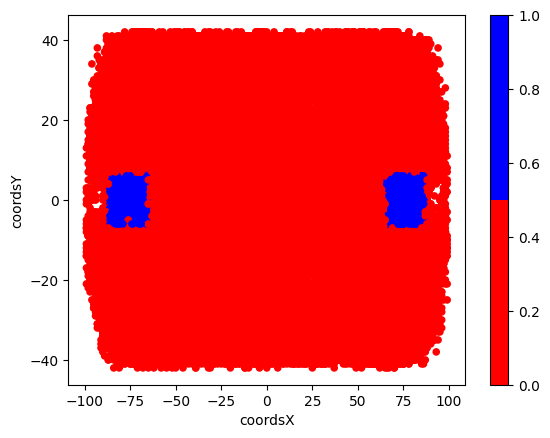

In [72]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['red', 'blue'])

# Create a scatter plot with 'highDangerChance' mapped to colors
sc = play_by_play.plot(x='coordsX', y='coordsY', kind='scatter',
                       c=play_by_play['highDangerChance'], cmap=cmap)